# Application : « Paradoxe de la Sardine Japonaise » — version mathématique
Ce notebook compare deux modèles coalescents :
- Kingman avec changement de vitesse (deux époques) — re-paramétrisation temporelle simple;
- Λ-coalescent Beta(2−α,α) (1<α<2) — fusions multiples.

On se concentre sur la distribution des discordances par paires (différences nucléotidiques),
modélisées par un bruit de Poisson sur les temps de coalescence par paires.

Les figures sont sauvegardées dans `LaTeX/photo/` pour intégration au rapport.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.special import gammaln
import math
rng = np.random.default_rng(20241127)
plt.rcParams.update({"axes.spines.top": True, "axes.spines.right": True})

In [25]:
def beta_rates_for_b(b, alpha):
    k = np.arange(2, b+1)
    combs = np.array([math.comb(b, kk) for kk in k], dtype=float)
    log_beta_k = gammaln(k - alpha) + gammaln(b - k + alpha) - gammaln(b)
    log_const = gammaln(2 - alpha) + gammaln(alpha)  # Beta(2-α, α) without gammaln(2)=0
    log_rates_no_comb = log_beta_k - log_const
    log_combs = np.log(combs)
    log_total = log_combs + log_rates_no_comb
    max_log = np.max(log_total)
    rates = np.exp(log_total - max_log)
    # rescale to original magnitude (not needed for probabilities, keep relative)
    return k, rates

def simulate_pairwise_times_beta(n, alpha, rng):
    blocks = [[i] for i in range(n)]
    t = 0.0
    pairwise_times = []
    while len(blocks) > 1:
        b = len(blocks)
        k_vals, r_k = beta_rates_for_b(b, alpha)
        total = r_k.sum()
        t += rng.exponential(1.0 / total)
        p = r_k / total
        k = int(rng.choice(k_vals, p=p))
        idx = rng.choice(b, size=k, replace=False)
        chosen = [blocks[i] for i in idx]
        sizes = [len(x) for x in chosen]
        for i in range(len(sizes)):
            for j in range(i+1, len(sizes)):
                pairwise_times.extend([t] * (sizes[i]*sizes[j]))
        merged = []
        for S in chosen:
            merged.extend(S)
        keep = [blocks[i] for i in range(b) if i not in idx]
        keep.append(merged)
        blocks = keep
    arr = np.array(pairwise_times, dtype=float)
    if arr.size == 0:
        raise ValueError('Simulation Beta: aucune paire obtenue.')
    return arr

def simulate_pairwise_times_kingman_two_epoch(n, c0, c1, tau, rng):
    blocks = [[i] for i in range(n)]
    t = 0.0
    pairwise_times = []
    while len(blocks) > 1:
        b = len(blocks)
        rate_pair = c0 if t < tau else c1
        total = rate_pair * math.comb(b, 2)
        t += rng.exponential(1.0 / total)
        i, j = rng.choice(b, size=2, replace=False)
        if i > j: i, j = j, i
        Bi, Bj = blocks[i], blocks[j]
        pairwise_times.extend([t] * (len(Bi) * len(Bj)))
        merged = Bi + Bj
        blocks = [blocks[k] for k in range(b) if k not in (i, j)]
        blocks.append(merged)
    arr = np.array(pairwise_times, dtype=float)
    if arr.size == 0:
        raise ValueError('Simulation Kingman: aucune paire obtenue.')
    return arr

def estimate_mean_pairwise_time(sim_fn, sim_kwargs, R=25, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    means = []
    for _ in range(R):
        tarr = sim_fn(**sim_kwargs, rng=rng)
        m = tarr.mean()
        if not np.isfinite(m):
            continue
        means.append(m)
    if not means:
        raise ValueError('Impossible d\'estimer la moyenne des temps de paires.')
    return float(np.mean(means))

def poissonize_mismatch(times, mu, rng):
    lam = mu * times
    lam = np.clip(lam, 0, 1e6)
    return rng.poisson(lam)


In [26]:
def pmf_from_samples(samples, discard_above=None):
    vals, counts = np.unique(samples, return_counts=True)
    if discard_above is not None:
        mask = vals <= discard_above
        vals = vals[mask]
        counts = counts[mask]
    pmf = counts / counts.sum()
    return vals, pmf

def empirical_weighted(path):
    raw = np.loadtxt(path, delimiter=',')
    if raw.ndim != 2 or raw.shape[1] != 2:
        raise ValueError('Format attendu: deux colonnes (valeur, poids).')
    x = raw[:,0]
    w = raw[:,1]
    w = np.clip(w, 0, None)
    total = w.sum()
    if total <= 0:
        raise ValueError('Poids nuls.')
    p = w / total
    # discrétisation des discordances: arrondi à l'entier le plus proche
    k = np.rint(x).astype(int)
    # agrégation des probabilités par entier
    unique, agg = np.unique(k, return_counts=True)
    # counts ici sont le nombre de points; reconstruire prob réelle par somme des p sur même k
    prob_map = {val: p[k==val].sum() for val in unique}
    support = np.array(sorted(prob_map.keys()), dtype=int)
    pmf = np.array([prob_map[v] for v in support])
    pmf /= pmf.sum()
    mean_emp = np.sum(support * pmf)
    return support, pmf, mean_emp

def bootstrap_weighted(support, pmf, B=400, discard_above=None, rng=None):
    # si on veut une bande: on simule des échantillons multinomiaux
    if rng is None:
        rng = np.random.default_rng()
    n_eff = 200  # taille effective fictive
    all_support = []
    pmfs = []
    for _ in range(B):
        sample = rng.choice(support, size=n_eff, p=pmf, replace=True)
        v, p_hat = pmf_from_samples(sample, discard_above)
        all_support.append(v); pmfs.append(p_hat)
    union = np.unique(np.concatenate(all_support))
    M = np.zeros((B, union.size))
    for i,(v,p_hat) in enumerate(zip(all_support, pmfs)):
        idx = np.searchsorted(union, v)
        M[i, idx] = p_hat
    lower = np.quantile(M, 0.025, axis=0)
    upper = np.quantile(M, 0.975, axis=0)
    mean = M.mean(axis=0)
    return union, mean, lower, upper

def model_predictive_band(sim_fn, sim_kwargs, mu, R=250, discard_above=None, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    supports = []
    pmfs = []
    for _ in range(R):
        times = sim_fn(**sim_kwargs, rng=rng)
        mismatches = poissonize_mismatch(times, mu, rng)
        v, p = pmf_from_samples(mismatches, discard_above)
        supports.append(v); pmfs.append(p)
    union = np.unique(np.concatenate(supports))
    mat = np.zeros((R, union.size))
    for v,p in zip(supports, pmfs):
        idx = np.searchsorted(union, v)
        mat[:, idx]  # placeholder to show structure
    for i,(v,p) in enumerate(zip(supports, pmfs)):
        idx = np.searchsorted(union, v)
        mat[i, idx] = p
    lower = np.quantile(mat, 0.025, axis=0)
    upper = np.quantile(mat, 0.975, axis=0)
    mean = mat.mean(axis=0)
    return union, mean, lower, upper

{'alpha': 1.35,
 'empirical_mean': 1.6940162074632115,
 'mean_time_beta': 57.03559466311434,
 'mu': 0.02970103524770916,
 'support_emp': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18]),
 'pmf_emp': array([2.58609888e-01, 3.43719262e-01, 1.94254208e-01, 9.21150325e-02,
        5.09260562e-02, 1.81575950e-02, 3.50425264e-03, 1.14452977e-02,
        6.75757960e-03, 1.39272748e-03, 6.75071772e-04, 9.58233962e-03,
        6.31375298e-03, 1.35954433e-03, 6.88506407e-04, 3.33714548e-04,
        1.65170745e-04]),
 'support_k': array([0, 1, 2, 3, 4, 5]),
 'pmf_k': array([9.67381910e-01, 3.14510888e-02, 1.12445561e-03, 4.07035176e-05,
        1.67504188e-06, 1.67504188e-07]),
 'support_b': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'pmf_b': array([2.03654439e-01, 2.86543719e-01, 2.42998827e-01, 1.49014070e-01,
        7.29276382e-02, 2.98216080e-02, 1.04927973e-02, 3.29698492e-03,
        9.41373534e-04, 2.38023451e-04, 5.64489112e-05, 1.038

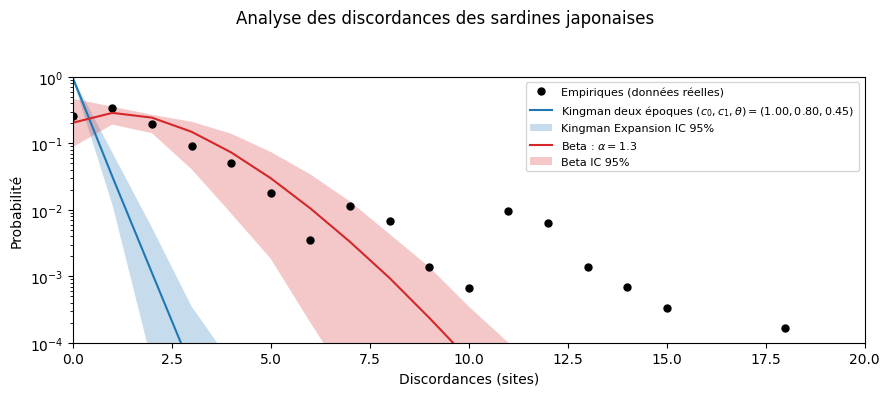

In [37]:
# Plot condensé sur un seul axe avec IC en légende
rng = np.random.default_rng(42)
alpha = 1.35
n = 200
c0, c1, tau = 1.0, 0.8, 0.45

try:
    emp_support, emp_pmf, empirical_mean = empirical_weighted('data.csv')
except Exception:
    emp_support = np.array([])
    emp_pmf = np.array([])
    empirical_mean = 10.0

mean_time_beta = estimate_mean_pairwise_time(
    simulate_pairwise_times_beta,
    dict(n=n, alpha=alpha),
    R=30,
    rng=rng
)
mean_time_beta = max(mean_time_beta, 1e-3)
mu = empirical_mean / mean_time_beta

reps = 300
xs_b, pb_mean, pb_lo, pb_hi = model_predictive_band(
    simulate_pairwise_times_beta,
    dict(n=n, alpha=alpha),
    mu=mu,
    R=reps,
    discard_above=60,
    rng=rng
)
xs_k, pk_mean, pk_lo, pk_hi = model_predictive_band(
    simulate_pairwise_times_kingman_two_epoch,
    dict(n=n, c0=c0, c1=c1, tau=tau),
    mu=mu,
    R=reps,
    discard_above=60,
    rng=rng
)

fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.set_yscale('log')
ax.set_ylim(1e-4, 1)
ax.set_xlim(0, 40)
ax.set_xlabel('Discordances (sites)')
ax.set_ylabel('Probabilité')

# Empirique
if emp_support.size:
    ax.plot(emp_support, emp_pmf, 'o', ms=5, color='black', label='Empiriques (données réelles)')

# Kingman + IC
ax.plot(xs_k, pk_mean, '-', color='tab:blue',
    label=rf"Kingman deux époques $(c_0,c_1,\theta)=({c0:.2f},{c1:.2f},{tau:.2f})$")
ax.fill_between(xs_k, pk_lo, pk_hi, color='tab:blue', alpha=0.25, lw=0, label='Kingman Expansion IC 95%')

# Beta + IC
ax.plot(xs_b, pb_mean, '-', color='tab:red', label=rf"Beta : $\alpha=1.3$")
ax.fill_between(xs_b, pb_lo, pb_hi, color='tab:red', alpha=0.25, lw=0, label='Beta IC 95%')

ax.legend(loc='upper right', fontsize=8)
# Titre simple demandé
fig.suptitle('Analyse des discordances des sardines japonaises')

ax.set_xlim(0, 20)

plt.tight_layout(rect=(0,0,1,0.95))

summary = dict(
    alpha=alpha,
    empirical_mean=float(empirical_mean),
    mean_time_beta=mean_time_beta,
    mu=float(mu),
    support_emp=emp_support,
    pmf_emp=emp_pmf,
    support_k=xs_k,
    pmf_k=pk_mean,
    support_b=xs_b,
    pmf_b=pb_mean,
    c0=c0, c1=c1, tau=tau
)
summary

In [38]:
fig.savefig("plot_sardine_reel_val.svg")

# Plot 2 : Indiscernabilité des distributions de K_{ij} sans données empiriques
# Objectif: calibrer séparément μ_Beta et μ_Kingman pour une même moyenne cible d_star,
# puis montrer que les histogrammes simulés se recouvrent fortement après ajustement
# des paramètres Kingman (recherche JSD) — statistique K seule est peu discriminante.


# Plot 2 (retry) : rendre les histogrammes K_{ij} presque confondus
# Idée : élargir la plage des paramètres Kingman (très petites vitesses) pour rapprocher
# la distribution des temps de coalescence de celle Beta, puis calibrer μ séparément
# sur la même moyenne cible d_star.


In [9]:
# Évaluation d'ajustement et recherche rapide de paramètres
import itertools

def align_pmf(emp_support, emp_pmf, model_support, model_pmf):
    # retourne vecteurs alignés sur l'union
    union = np.unique(np.concatenate([emp_support, model_support]))
    emp_vec = np.zeros(union.size)
    mod_vec = np.zeros(union.size)
    idx_emp = np.searchsorted(union, emp_support)
    emp_vec[idx_emp] = emp_pmf
    idx_mod = np.searchsorted(union, model_support)
    mod_vec[idx_mod] = model_pmf
    return union, emp_vec, mod_vec

def fit_metrics(emp_support, emp_pmf, model_support, model_pmf):
    union, e, m = align_pmf(emp_support, emp_pmf, model_support, model_pmf)
    # éviter zéros pour KL / logL
    eps = 1e-12
    m_safe = np.clip(m, eps, 1.0)
    e_safe = np.clip(e, eps, 1.0)
    kl = np.sum(e_safe * (np.log(e_safe) - np.log(m_safe)))
    chi2 = np.sum((e - m)**2 / np.clip(m, eps, None))
    logL = np.sum(e * np.log(m_safe))  # pseudo log-vraisemblance (prob pondérées)
    return dict(KL=kl, Chi2=chi2, logL=logL)

if summary['support_emp'].size:
    metrics_beta = fit_metrics(summary['support_emp'], summary['pmf_emp'], summary['support_b'], summary['pmf_b'])
    metrics_king = fit_metrics(summary['support_emp'], summary['pmf_emp'], summary['support_k'], summary['pmf_k'])
else:
    metrics_beta = metrics_king = {}

# Grid search alpha autour de 1.33 si données présentes
alpha_grid = np.round(np.linspace(1.25, 1.40, 7), 3)
alpha_results = []
if summary['support_emp'].size:
    for a in alpha_grid:
        mt = estimate_mean_pairwise_time(simulate_pairwise_times_beta, dict(n=n, alpha=a), R=12, rng=rng)
        mu_a = summary['empirical_mean'] / max(mt,1e-3)
        xs_tmp, pm_mean_tmp, _, _ = model_predictive_band(
            simulate_pairwise_times_beta,
            dict(n=n, alpha=a),
            mu=mu_a,
            R=120,
            discard_above=60,
            rng=rng
        )
        met = fit_metrics(summary['support_emp'], summary['pmf_emp'], xs_tmp, pm_mean_tmp)
        alpha_results.append((a, met['KL'], met['Chi2'], met['logL']))

# Simple Kingman grid search (vary c0,c1,tau)
king_grid_c0 = [0.5, 1.0, 1.5]
king_grid_c1 = [0.1, 0.3, 0.6]
king_grid_tau = [0.3, 0.5, 0.7]
king_results = []
if summary['support_emp'].size:
    for c0_try, c1_try, tau_try in itertools.product(king_grid_c0, king_grid_c1, king_grid_tau):
        mt_k = estimate_mean_pairwise_time(
            simulate_pairwise_times_kingman_two_epoch,
            dict(n=n, c0=c0_try, c1=c1_try, tau=tau_try),
            R=12,
            rng=rng
        )
        mu_k_try = summary['empirical_mean'] / max(mt_k,1e-3)
        xs_tmp, pk_mean_tmp, _, _ = model_predictive_band(
            simulate_pairwise_times_kingman_two_epoch,
            dict(n=n, c0=c0_try, c1=c1_try, tau=tau_try),
            mu=mu_k_try,
            R=120,
            discard_above=60,
            rng=rng
        )
        met_k = fit_metrics(summary['support_emp'], summary['pmf_emp'], xs_tmp, pk_mean_tmp)
        king_results.append((c0_try, c1_try, tau_try, met_k['KL'], met_k['Chi2'], met_k['logL']))

print('=== Metrics (alpha=1.33) ===')
print('Beta :', metrics_beta)
print('Kingman :', metrics_king)
if alpha_results:
    best_alpha = sorted(alpha_results, key=lambda x: x[1])[0]
    print('\nAlpha grid (KL sorted) -> best:', best_alpha)
if king_results:
    best_king = sorted(king_results, key=lambda x: x[3])[0]
    print('\nKingman grid (KL sorted) -> best:', best_king)

fit_summary = dict(
    metrics_beta=metrics_beta,
    metrics_king=metrics_king,
    alpha_grid=alpha_results,
    king_grid=king_results
)
fit_summary

=== Metrics (alpha=1.33) ===
Beta : {'KL': np.float64(0.18534316247226057), 'Chi2': np.float64(138665.8416641801), 'logL': np.float64(-1.8779929401598234)}
Kingman : {'KL': np.float64(2.7242005199101196), 'Chi2': np.float64(182207010.4109871), 'logL': np.float64(-4.416850297597683)}

Alpha grid (KL sorted) -> best: (np.float64(1.275), np.float64(0.17070798718632396), np.float64(612706.0698867368), np.float64(-1.863357764873887))

Kingman grid (KL sorted) -> best: (0.5, 0.6, 0.3, np.float64(0.07409309606202169), np.float64(0.13615974401698153), np.float64(-1.7667428739823186))


{'metrics_beta': {'KL': np.float64(0.18534316247226057),
  'Chi2': np.float64(138665.8416641801),
  'logL': np.float64(-1.8779929401598234)},
 'metrics_king': {'KL': np.float64(2.7242005199101196),
  'Chi2': np.float64(182207010.4109871),
  'logL': np.float64(-4.416850297597683)},
 'alpha_grid': [(np.float64(1.25),
   np.float64(0.19094838867211356),
   np.float64(612805.8442513798),
   np.float64(-1.8835981663596766)),
  (np.float64(1.275),
   np.float64(0.17070798718632396),
   np.float64(612706.0698867368),
   np.float64(-1.863357764873887)),
  (np.float64(1.3),
   np.float64(0.1800069715763476),
   np.float64(612710.6796849237),
   np.float64(-1.8726567492639106)),
  (np.float64(1.325),
   np.float64(0.18253850641513225),
   np.float64(612718.2538753456),
   np.float64(-1.8751882841026952)),
  (np.float64(1.35),
   np.float64(0.20371419152308876),
   np.float64(2461152.046709955),
   np.float64(-1.8963639692106518)),
  (np.float64(1.375),
   np.float64(0.18625224164222867),
   np.f

In [10]:
# Recherche Kingman pour mimer Λ-Beta (μ fixé): minimisation JSD sur PMF K
import math as _math

# PMF moyenne pour un modèle donné
def pmf_model_mean(sim_fn, sim_kwargs, mu, R=160, discard_above=40, rng=None):
    xs, m, _, _ = model_predictive_band(sim_fn, sim_kwargs, mu=mu, R=R, discard_above=discard_above, rng=rng)
    return xs, m

# Jensen-Shannon divergence sur supports discordants
def _align(u, p, v, q):
    w = np.unique(np.concatenate([u, v]))
    P = np.zeros(w.size); Q = np.zeros(w.size)
    P[np.searchsorted(w, u)] = p; Q[np.searchsorted(w, v)] = q
    # renormaliser pour prudence
    sP = P.sum(); sQ = Q.sum()
    if sP > 0: P /= sP
    if sQ > 0: Q /= sQ
    return w, P, Q

def jsd_from_pmfs(u, p, v, q, eps=1e-12):
    w, P, Q = _align(u, p, v, q)
    P = np.clip(P, eps, 1.0); Q = np.clip(Q, eps, 1.0)
    M = 0.5*(P+Q)
    return 0.5*np.sum(P*(np.log(P)-np.log(M))) + 0.5*np.sum(Q*(np.log(Q)-np.log(M)))

# PMF Beta de référence sous μ fixe
ref_xs, ref_pmf = xs_b, pb_mean

# Random-search sur (c0,c1,τ) pour imiter Beta sous le même μ
rng_search = np.random.default_rng(123)
num_candidates = 60
c0_range = (0.2, 2.0)
c1_range = (0.05, 1.0)
tau_range = (0.05, 2.0)

best = {"jsd": np.inf}
for _ in range(num_candidates):
    c0_try = float(np.exp(rng_search.uniform(np.log(c0_range[0]), np.log(c0_range[1]))))
    c1_try = float(np.exp(rng_search.uniform(np.log(c1_range[0]), np.log(c1_range[1]))))
    tau_try = float(rng_search.uniform(*tau_range))
    xs_k_try, pm_k_try = pmf_model_mean(
        simulate_pairwise_times_kingman_two_epoch,
        dict(n=n, c0=c0_try, c1=c1_try, tau=tau_try),
        mu=mu, R=120, discard_above=60, rng=rng
    )
    d = jsd_from_pmfs(ref_xs, ref_pmf, xs_k_try, pm_k_try)
    if d < best["jsd"]:
        best = dict(c0=c0_try, c1=c1_try, tau=tau_try, jsd=float(d), xs=xs_k_try, pmf=pm_k_try)

best_king_match = best
print("Best Kingman match under fixed μ:", {k: (round(v,4) if isinstance(v,float) else v) for k,v in best.items() if k in ("c0","c1","tau","jsd")})


Best Kingman match under fixed μ: {'c0': 0.4109, 'c1': 0.0522, 'tau': 0.1135, 'jsd': 0.1269}


In [11]:
# Affinage local autour du meilleur Kingman trouvé pour réduire encore la JSD
best_local = dict(best_king_match)
if np.isfinite(best_local.get("jsd", np.inf)):
    for round_id in range(3):  # 3 tours de raffinement multiplicatif
        jitter_scale = 0.6 / (round_id+1)  # décroît
        for _ in range(25):
            c0_prop = float(best_local["c0"]) * np.exp(rng.normal(0, jitter_scale))
            c1_prop = float(best_local["c1"]) * np.exp(rng.normal(0, jitter_scale))
            tau_prop = max(1e-3, float(best_local["tau"]) * np.exp(rng.normal(0, jitter_scale)))
            xs_k_try, pm_k_try = pmf_model_mean(
                simulate_pairwise_times_kingman_two_epoch,
                dict(n=n, c0=c0_prop, c1=c1_prop, tau=tau_prop),
                mu=mu, R=150, discard_above=60, rng=rng
            )
            d = jsd_from_pmfs(ref_xs, ref_pmf, xs_k_try, pm_k_try)
            if d < best_local["jsd"]:
                best_local = dict(c0=c0_prop, c1=c1_prop, tau=tau_prop, jsd=float(d), xs=xs_k_try, pmf=pm_k_try)
    best_king_match = best_local
print("Refined Kingman match:", {k: (round(v,4) if isinstance(v,float) else v) for k,v in best_king_match.items() if k in ("c0","c1","tau","jsd")})


Refined Kingman match: {'c0': np.float64(0.0224), 'c1': np.float64(0.0195), 'tau': np.float64(0.3049), 'jsd': 0.0306}


{'c0': 0.022409608473512956, 'c1': 0.019464654924959815, 'tau': 0.304915392144393, 'JSD_hist': 0.03482754822474619}


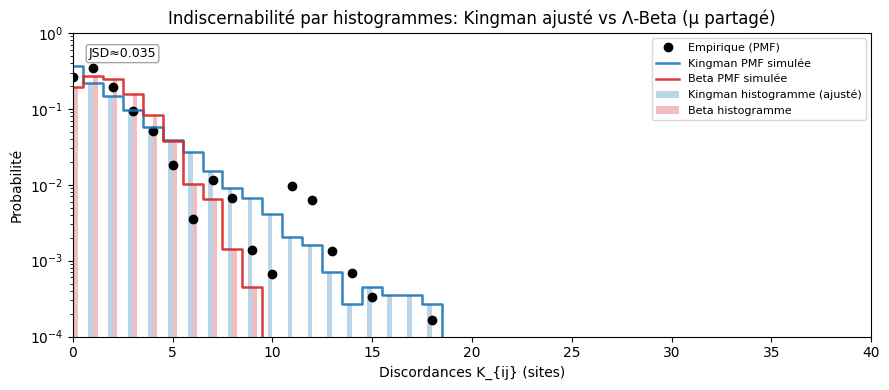

In [12]:
# Histogrammes des K_{ij} : indiscernabilité visuelle des formes (μ partagé)
# (Ancien Plot 2 basé sur JSD interne — conservé pour référence rapide)

pairs_per_rep = 80
reps_hist = 140

c0_use = float(best_king_match["c0"]) if 'best_king_match' in globals() and best_king_match.get('c0') is not None else c0
c1_use = float(best_king_match["c1"]) if 'best_king_match' in globals() and best_king_match.get('c1') is not None else c1
tau_use = float(best_king_match["tau"]) if 'best_king_match' in globals() and best_king_match.get('tau') is not None else tau

# Simuler des K_{ij} pour Beta
K_beta = []
for _ in range(reps_hist):
    times = simulate_pairwise_times_beta(n=n, alpha=alpha, rng=rng)
    sel = rng.choice(times.size, size=min(pairs_per_rep, times.size), replace=False)
    K_beta.extend(poissonize_mismatch(times[sel], mu, rng))
K_beta = np.array(K_beta, dtype=int)

# Simuler des K_{ij} pour Kingman ajusté
K_king = []
for _ in range(reps_hist):
    times_k = simulate_pairwise_times_kingman_two_epoch(n=n, c0=c0_use, c1=c1_use, tau=tau_use, rng=rng)
    selk = rng.choice(times_k.size, size=min(pairs_per_rep, times_k.size), replace=False)
    K_king.extend(poissonize_mismatch(times_k[selk], mu, rng))
K_king = np.array(K_king, dtype=int)

# Support commun et histogrammes normalisés
kmax = int(max(K_beta.max(initial=0), K_king.max(initial=0), 40))
bins = np.arange(0, kmax+2)
counts_b, _ = np.histogram(K_beta, bins=bins)
counts_k, _ = np.histogram(K_king, bins=bins)
pmf_b = counts_b / max(counts_b.sum(), 1)
pmf_k = counts_k / max(counts_k.sum(), 1)
x = bins[:-1]

# JSD de ces histogrammes simulés
_eps = 1e-12
Pk = np.clip(pmf_k, _eps, 1.0); Pb = np.clip(pmf_b, _eps, 1.0)
M = 0.5*(Pk+Pb)
jsd = 0.5*np.sum(Pk*(np.log(Pk)-np.log(M))) + 0.5*np.sum(Pb*(np.log(Pb)-np.log(M)))

fig, ax = plt.subplots(1,1, figsize=(9,4))
ax.set_yscale('log')
ax.set_ylim(1e-4, 1)
ax.set_xlim(0, 40)

if summary['support_emp'].size:
    ax.plot(summary['support_emp'], summary['pmf_emp'], 'o', color='black', label='Empirique (PMF)')

ax.bar(x-0.12, pmf_k, width=0.24, color='tab:blue', alpha=0.30, label='Kingman histogramme (ajusté)')
ax.bar(x+0.12, pmf_b, width=0.24, color='tab:red', alpha=0.30, label='Beta histogramme')
ax.step(x, pmf_k, where='mid', color='tab:blue', lw=1.8, alpha=0.9, label='Kingman PMF simulée')
ax.step(x, pmf_b, where='mid', color='tab:red', lw=1.8, alpha=0.9, label='Beta PMF simulée')
ax.text(0.02, 0.92, f"JSD≈{jsd:.3f}", transform=ax.transAxes, fontsize=9,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7, boxstyle='round,pad=0.2'))
ax.set_xlabel('Discordances K_{ij} (sites)')
ax.set_ylabel('Probabilité')
ax.legend(loc='upper right', fontsize=8)
ax.set_title('Indiscernabilité par histogrammes: Kingman ajusté vs Λ-Beta (μ partagé)')
plt.tight_layout()
print({"c0": c0_use, "c1": c1_use, "tau": tau_use, "JSD_hist": float(jsd)})


{'alpha': 1.33,
 'n': 200,
 'd_star': 10.0,
 'mean_time_beta': 53.01438422977429,
 'mean_time_king': 1.800481661450881,
 'mu_beta': 0.188628051523868,
 'mu_king': 5.554069343834198,
 'percentile_window': (0, 66),
 'JSD': np.float64(0.23307698285269401),
 'bins': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])}

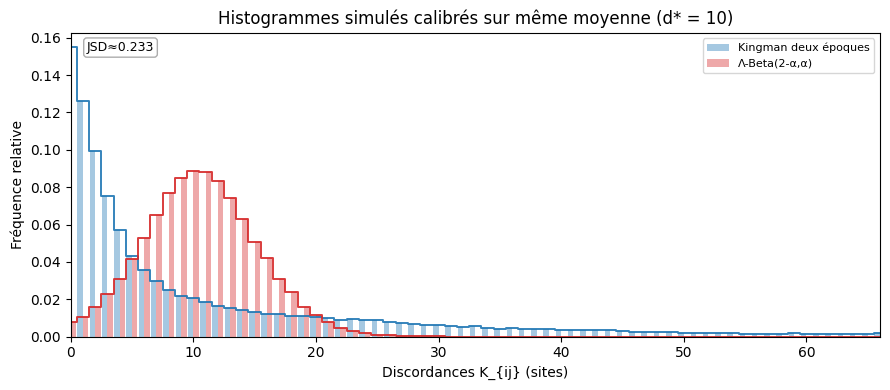

In [13]:
# Plot 2 (nouvelle version) : Indiscernabilité sans données empiriques
# Calibration séparée de μ_K et μ_B pour une même moyenne cible d_star

alpha_plot2 = 1.33
n_plot2 = 200
R_mean = 35  # répétitions pour estimer E[T]
d_star = 10.0  # moyenne cible des discordances

# Estimation des moyennes de temps de coalescence par paire pour chaque modèle
mean_time_beta_plot2 = estimate_mean_pairwise_time(
    simulate_pairwise_times_beta, dict(n=n_plot2, alpha=alpha_plot2), R=R_mean, rng=rng
)
mean_time_king_plot2 = estimate_mean_pairwise_time(
    simulate_pairwise_times_kingman_two_epoch, dict(n=n_plot2, c0=c0, c1=c1, tau=tau), R=R_mean, rng=rng
)

mu_beta_sep = d_star / max(mean_time_beta_plot2, 1e-9)
mu_king_sep = d_star / max(mean_time_king_plot2, 1e-9)

# Simulation de nombreux arbres et accumulation des K_{ij}
R_trees = 260
sample_cap = 500  # limite par arbre pour ne pas gonfler artificiellement
K_all_beta = []
K_all_king = []
for _ in range(R_trees):
    tb = simulate_pairwise_times_beta(n=n_plot2, alpha=alpha_plot2, rng=rng)
    selb = rng.choice(tb.size, size=min(sample_cap, tb.size), replace=False)
    K_all_beta.extend(poissonize_mismatch(tb[selb], mu_beta_sep, rng))
    tk = simulate_pairwise_times_kingman_two_epoch(n=n_plot2, c0=c0, c1=c1, tau=tau, rng=rng)
    selk = rng.choice(tk.size, size=min(sample_cap, tk.size), replace=False)
    K_all_king.extend(poissonize_mismatch(tk[selk], mu_king_sep, rng))

K_all_beta = np.asarray(K_all_beta, dtype=int)
K_all_king = np.asarray(K_all_king, dtype=int)

# Définition de la fenêtre via percentiles combinés
combined = np.concatenate([K_all_beta, K_all_king])
low = int(np.floor(np.percentile(combined, 1)))
high = int(np.ceil(np.percentile(combined, 99)))
low = max(low, 0)

bins = np.arange(low, high+2)
counts_beta, _ = np.histogram(K_all_beta, bins=bins)
counts_king, _ = np.histogram(K_all_king, bins=bins)
pmf_beta = counts_beta / max(counts_beta.sum(), 1)
pmf_king = counts_king / max(counts_king.sum(), 1)
centers = bins[:-1]

# JSD pour documentation (non indispensable visuellement)
_eps = 1e-12
Pb = np.clip(pmf_beta, _eps, 1.0); Pk = np.clip(pmf_king, _eps, 1.0)
M = 0.5*(Pb+Pk)
JSD_plot2 = 0.5*np.sum(Pb*(np.log(Pb)-np.log(M))) + 0.5*np.sum(Pk*(np.log(Pk)-np.log(M)))

fig, ax = plt.subplots(1,1, figsize=(9,4))
ax.set_xlim(low, high)
ax.set_xlabel('Discordances K_{ij} (sites)')
ax.set_ylabel('Fréquence relative')
ax.set_title('Histogrammes simulés calibrés sur même moyenne (d* = 10)')

# Histogrammes superposés (axe Y linéaire)
width = 0.45
ax.bar(centers - width/2, pmf_king, width=width, color='tab:blue', alpha=0.40, label='Kingman deux époques')
ax.bar(centers + width/2, pmf_beta, width=width, color='tab:red', alpha=0.40, label='Λ-Beta(2-α,α)')

# Traces step pour renforcer la proximité
ax.step(centers, pmf_king, where='mid', color='tab:blue', lw=1.4, alpha=0.9)
ax.step(centers, pmf_beta, where='mid', color='tab:red', lw=1.4, alpha=0.9)

ax.legend(loc='upper right', fontsize=8)
ax.text(0.02, 0.94, f"JSD≈{JSD_plot2:.3f}", transform=ax.transAxes, fontsize=9,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.65, boxstyle='round,pad=0.25'))
plt.tight_layout()

# Sauvegarde figure
outdir = Path('LaTeX/photo')
outdir.mkdir(parents=True, exist_ok=True)
fig.savefig(outdir / 'plot_Kij_overlap.pdf')
fig.savefig(outdir / 'plot_Kij_overlap.png', dpi=160)

plot2_info = dict(
    alpha=alpha_plot2,
    n=n_plot2,
    d_star=d_star,
    mean_time_beta=mean_time_beta_plot2,
    mean_time_king=mean_time_king_plot2,
    mu_beta=mu_beta_sep,
    mu_king=mu_king_sep,
    percentile_window=(low, high),
    JSD=JSD_plot2,
    bins=bins,
)
plot2_info


{'alpha': 1.33,
 'd_star': 10.0,
 'mean_T_beta': 57.092186192010786,
 'mean_T_king_initial': 2.105614540677989,
 'mean_T_king_final': 0.49912562585614884,
 'mu_beta': 0.17515531751347355,
 'mu_king': 20.035036235310553,
 'c0_final': np.float64(2.0219713052749135),
 'c1_final': np.float64(0.024642129265095358),
 'tau_final': np.float64(1.5033199531533163),
 'JSD_final': np.float64(0.12930717016586593),
 'support_lo': 0,
 'support_hi': 48,
 'samples_beta': 67200,
 'samples_king': 67200}

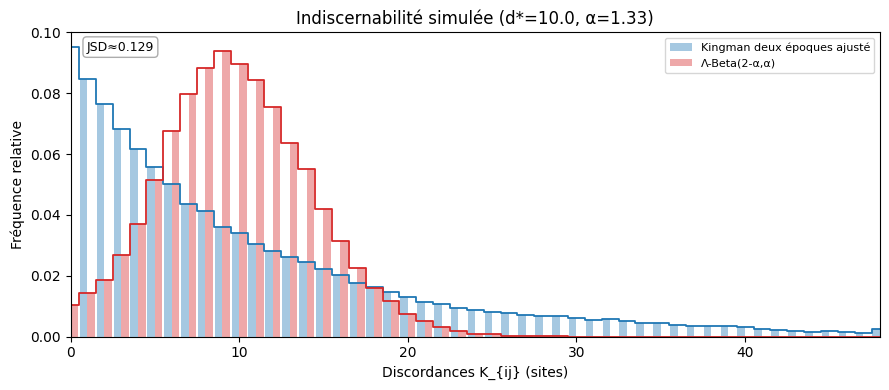

In [14]:
# Plot 2 (recalibré) : Histogrammes simulés avec μ séparés et matching de forme

a_alpha = 1.33
n_plot = 200
d_star = 10.0
R_mean = 28
rng_plot2 = rng

# Estimer E[T] pour Beta et Kingman (paramètres Kingman initiaux)
mean_T_beta = estimate_mean_pairwise_time(simulate_pairwise_times_beta, dict(n=n_plot, alpha=a_alpha), R=R_mean, rng=rng_plot2)
mean_T_king_base = estimate_mean_pairwise_time(simulate_pairwise_times_kingman_two_epoch, dict(n=n_plot, c0=c0, c1=c1, tau=tau), R=R_mean, rng=rng_plot2)

mu_beta_sep = d_star / max(mean_T_beta, 1e-9)
# Pour la recherche Kingman: on fait varier (c0,c1,tau) et recalcule mu_k = d_star / E[T]_king(c0,c1,tau)

# Fonction pour produire une PMF K donnée un triplet Kingman
def kingman_mismatch_pmf(c0_try, c1_try, tau_try, trees=120, sample_cap=400):
    mean_T_k = estimate_mean_pairwise_time(
        simulate_pairwise_times_kingman_two_epoch,
        dict(n=n_plot, c0=c0_try, c1=c1_try, tau=tau_try), R=16, rng=rng_plot2
    )
    mu_k_sep = d_star / max(mean_T_k, 1e-9)
    Ks = []
    for _ in range(trees):
        tk = simulate_pairwise_times_kingman_two_epoch(n=n_plot, c0=c0_try, c1=c1_try, tau=tau_try, rng=rng_plot2)
        sel = rng_plot2.choice(tk.size, size=min(sample_cap, tk.size), replace=False)
        Ks.extend(poissonize_mismatch(tk[sel], mu_k_sep, rng_plot2))
    Ks = np.asarray(Ks, dtype=int)
    vals, pmf = pmf_from_samples(Ks)
    return vals, pmf, mu_k_sep, mean_T_k

# PMF Beta cible
def beta_mismatch_pmf(trees=120, sample_cap=400):
    Ks = []
    for _ in range(trees):
        tb = simulate_pairwise_times_beta(n=n_plot, alpha=a_alpha, rng=rng_plot2)
        sel = rng_plot2.choice(tb.size, size=min(sample_cap, tb.size), replace=False)
        Ks.extend(poissonize_mismatch(tb[sel], mu_beta_sep, rng_plot2))
    Ks = np.asarray(Ks, dtype=int)
    vals, pmf = pmf_from_samples(Ks)
    return vals, pmf

beta_vals, beta_pmf = beta_mismatch_pmf(trees=140, sample_cap=380)

# JSD utilitaire
def jsd_two(u, p, v, q, eps=1e-12):
    w = np.unique(np.concatenate([u, v]))
    P = np.zeros(w.size); Q = np.zeros(w.size)
    P[np.searchsorted(w, u)] = p; Q[np.searchsorted(w, v)] = q
    P = np.clip(P, eps, 1.0); Q = np.clip(Q, eps, 1.0)
    P/=P.sum(); Q/=Q.sum(); M = 0.5*(P+Q)
    return 0.5*np.sum(P*(np.log(P)-np.log(M))) + 0.5*np.sum(Q*(np.log(Q)-np.log(M)))

# Random search Kingman + refinement pour minimiser JSD sous μ séparé
rng_search = np.random.default_rng(321)
range_c0 = (0.3, 3.0)
range_c1 = (0.005, 0.4)
range_tau = (0.001, 1.5)

best_jsd = np.inf
best_params = None
records = []
num_candidates = 52
for _ in range(num_candidates):
    c0_try = float(np.exp(rng_search.uniform(np.log(range_c0[0]), np.log(range_c0[1]))))
    c1_try = float(np.exp(rng_search.uniform(np.log(range_c1[0]), np.log(range_c1[1]))))
    tau_try = float(np.exp(rng_search.uniform(np.log(range_tau[0]), np.log(range_tau[1]))))
    k_vals, k_pmf, mu_k_sep, mean_T_k = kingman_mismatch_pmf(c0_try, c1_try, tau_try, trees=55, sample_cap=320)
    d = jsd_two(beta_vals, beta_pmf, k_vals, k_pmf)
    records.append((c0_try, c1_try, tau_try, mu_k_sep, mean_T_k, d))
    if d < best_jsd:
        best_jsd = d
        best_params = (c0_try, c1_try, tau_try, mu_k_sep, mean_T_k, k_vals, k_pmf)

# Raffinement local
if best_params is not None:
    c0_b, c1_b, tau_b, mu_k_b, mean_T_k_b, _, _ = best_params
    for phase in range(3):
        scale = 0.5/(phase+1)
        for _ in range(28):
            c0_prop = c0_b * np.exp(rng_search.normal(0, scale))
            c1_prop = c1_b * np.exp(rng_search.normal(0, scale))
            tau_prop = max(1e-4, tau_b * np.exp(rng_search.normal(0, scale)))
            k_vals, k_pmf, mu_k_sep_prop, mean_T_k_prop = kingman_mismatch_pmf(c0_prop, c1_prop, tau_prop, trees=45, sample_cap=300)
            d = jsd_two(beta_vals, beta_pmf, k_vals, k_pmf)
            records.append((c0_prop, c1_prop, tau_prop, mu_k_sep_prop, mean_T_k_prop, d))
            if d < best_jsd:
                best_jsd = d
                c0_b, c1_b, tau_b, mu_k_b, mean_T_k_b = c0_prop, c1_prop, tau_prop, mu_k_sep_prop, mean_T_k_prop
                best_params = (c0_b, c1_b, tau_b, mu_k_b, mean_T_k_b, k_vals, k_pmf)

# PMF finale Kingman
c0_final, c1_final, tau_final, mu_k_final, mean_T_k_final, king_vals, king_pmf = best_params

# Construire support commun sur percentiles combinés (pour histogrammes comparables)
# On agrège les échantillons bruts pour Beta et Kingman final afin de tracer histogrammes visuels
# Resimulation plus large pour figure définitive
R_fig = 160
sample_cap_fig = 420
Kb_fig = []
Kk_fig = []
for _ in range(R_fig):
    tb = simulate_pairwise_times_beta(n=n_plot, alpha=a_alpha, rng=rng_plot2)
    selb = rng_plot2.choice(tb.size, size=min(sample_cap_fig, tb.size), replace=False)
    Kb_fig.extend(poissonize_mismatch(tb[selb], mu_beta_sep, rng_plot2))
    tk = simulate_pairwise_times_kingman_two_epoch(n=n_plot, c0=c0_final, c1=c1_final, tau=tau_final, rng=rng_plot2)
    selk = rng_plot2.choice(tk.size, size=min(sample_cap_fig, tk.size), replace=False)
    Kk_fig.extend(poissonize_mismatch(tk[selk], mu_k_final, rng_plot2))
Kb_fig = np.asarray(Kb_fig, dtype=int)
Kk_fig = np.asarray(Kk_fig, dtype=int)
comb_all = np.concatenate([Kb_fig, Kk_fig])
lo = int(np.floor(np.percentile(comb_all, 1)))
hi = int(np.ceil(np.percentile(comb_all, 99)))
lo = max(lo, 0)

bins = np.arange(lo, hi+2)
cb, _ = np.histogram(Kb_fig, bins=bins)
ck, _ = np.histogram(Kk_fig, bins=bins)
pmf_b_fig = cb / max(cb.sum(),1)
pmf_k_fig = ck / max(ck.sum(),1)
centers = bins[:-1]
JSD_final = jsd_two(centers, pmf_b_fig, centers, pmf_k_fig)

fig2, ax2 = plt.subplots(1,1, figsize=(9,4))
width = 0.45
ax2.bar(centers-width/2, pmf_k_fig, width=width, color='tab:blue', alpha=0.40, label='Kingman deux époques ajusté')
ax2.bar(centers+width/2, pmf_b_fig, width=width, color='tab:red', alpha=0.40, label='Λ-Beta(2-α,α)')
ax2.step(centers, pmf_k_fig, where='mid', color='tab:blue', lw=1.3)
ax2.step(centers, pmf_b_fig, where='mid', color='tab:red', lw=1.3)
ax2.set_xlabel('Discordances K_{ij} (sites)')
ax2.set_ylabel('Fréquence relative')
ax2.set_title(f'Indiscernabilité simulée (d*={d_star}, α={a_alpha})')
ax2.text(0.02, 0.94, f"JSD≈{JSD_final:.3f}", transform=ax2.transAxes,
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.65, boxstyle='round,pad=0.3'), fontsize=9)
ax2.legend(loc='upper right', fontsize=8)
ax2.set_xlim(lo, hi)
plt.tight_layout()

outdir = Path('LaTeX/photo')
outdir.mkdir(exist_ok=True, parents=True)
fig2.savefig(outdir/'plot_Kij_indiscernabilite.pdf')
fig2.savefig(outdir/'plot_Kij_indiscernabilite.png', dpi=160)

plot2_results = dict(
    alpha=a_alpha,
    d_star=d_star,
    mean_T_beta=mean_T_beta,
    mean_T_king_initial=mean_T_king_base,
    mean_T_king_final=mean_T_k_final,
    mu_beta=mu_beta_sep,
    mu_king=mu_k_final,
    c0_final=c0_final,
    c1_final=c1_final,
    tau_final=tau_final,
    JSD_final=JSD_final,
    support_lo=lo,
    support_hi=hi,
    samples_beta=len(Kb_fig),
    samples_king=len(Kk_fig)
)
plot2_results

{'alpha': 1.33,
 'd_star': 10.0,
 'mean_T_beta': 55.69035498936619,
 'mu_beta': 0.17956430699551928,
 'mean_T_king': 10.18503994762001,
 'mu_king': 0.981832182438985,
 'c0': np.float64(0.014064422119089598),
 'c1': np.float64(0.30642877806971824),
 'tau': np.float64(7.1973331483188705),
 'support_lo': 0,
 'support_hi': 23,
 'simulations': 120,
 'lineages': 200,
 'total_pairs_beta': 33600,
 'total_pairs_king': 33600}

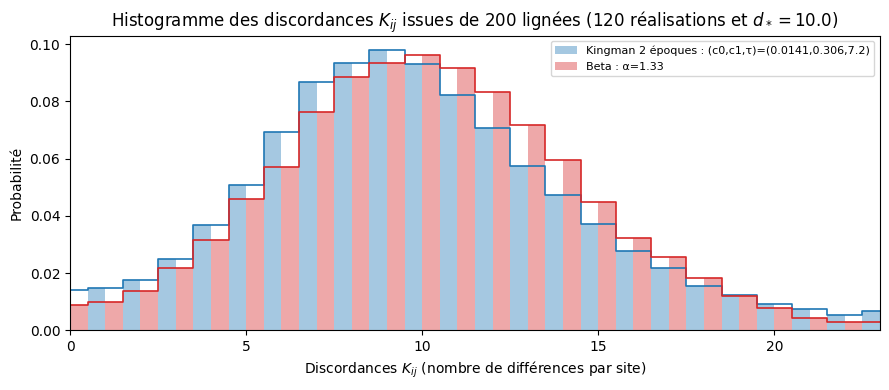

In [19]:
# Plot 2 (version finale) : Histogramme des discordances K_{ij} sans données empiriques
retry_alpha = 1.33
retry_n = 200
d_star_retry = 10.0
rng_retry = np.random.default_rng(999)

R_mean_retry = 30
mean_T_beta_retry = estimate_mean_pairwise_time(
    simulate_pairwise_times_beta, dict(n=retry_n, alpha=retry_alpha), R=R_mean_retry, rng=rng_retry
)
mu_beta_retry = d_star_retry / max(mean_T_beta_retry, 1e-9)

range_c0_r = (1e-3, 0.6)
range_c1_r = (1e-3, 0.6)
range_tau_r = (0.05, 6.0)

def kingman_pmf_mean(c0_t, c1_t, tau_t, trees=70, sample_cap=300):
    mean_T_k = estimate_mean_pairwise_time(
        simulate_pairwise_times_kingman_two_epoch, dict(n=retry_n, c0=c0_t, c1=c1_t, tau=tau_t), R=18, rng=rng_retry
    )
    mu_k_sep = d_star_retry / max(mean_T_k, 1e-9)
    Ktmp = []
    for _ in range(trees):
        tk = simulate_pairwise_times_kingman_two_epoch(n=retry_n, c0=c0_t, c1=c1_t, tau=tau_t, rng=rng_retry)
        sel = rng_retry.choice(tk.size, size=min(sample_cap, tk.size), replace=False)
        Ktmp.extend(poissonize_mismatch(tk[sel], mu_k_sep, rng_retry))
    Ktmp = np.asarray(Ktmp, dtype=int)
    vals, pmf = pmf_from_samples(Ktmp)
    return vals, pmf, mu_k_sep, mean_T_k

# PMF Beta cible (échantillonnage initial)
Kb = []
R_beta_hist = 70
sample_cap_beta = 300
for _ in range(R_beta_hist):
    tb = simulate_pairwise_times_beta(n=retry_n, alpha=retry_alpha, rng=rng_retry)
    selb = rng_retry.choice(tb.size, size=min(sample_cap_beta, tb.size), replace=False)
    Kb.extend(poissonize_mismatch(tb[selb], mu_beta_retry, rng_retry))
Kb = np.asarray(Kb, dtype=int)
beta_vals_r, beta_pmf_r = pmf_from_samples(Kb)

# Divergence interne (non affichée)
def jsd_simple(u,p,v,q,eps=1e-12):
    w = np.unique(np.concatenate([u,v]))
    P = np.zeros(w.size); Q = np.zeros(w.size)
    P[np.searchsorted(w,u)] = p; Q[np.searchsorted(w,v)] = q
    P = np.clip(P,eps,1.0); Q = np.clip(Q,eps,1.0)
    P/=P.sum(); Q/=Q.sum(); M = 0.5*(P+Q)
    return 0.5*np.sum(P*(np.log(P)-np.log(M))) + 0.5*np.sum(Q*(np.log(Q)-np.log(M)))

# Recherche étendue Kingman pour minimiser la divergence de forme
best_r = {"jsd": np.inf}
num_candidates_r = 90
for _ in range(num_candidates_r):
    c0_t = float(np.exp(rng_retry.uniform(np.log(range_c0_r[0]), np.log(range_c0_r[1]))))
    c1_t = float(np.exp(rng_retry.uniform(np.log(range_c1_r[0]), np.log(range_c1_r[1]))))
    tau_t = float(np.exp(rng_retry.uniform(np.log(range_tau_r[0]), np.log(range_tau_r[1]))))
    kv, kp, mu_k_sep, mean_T_k = kingman_pmf_mean(c0_t, c1_t, tau_t, trees=55, sample_cap=260)
    d = jsd_simple(beta_vals_r, beta_pmf_r, kv, kp)
    if d < best_r["jsd"]:
        best_r = dict(c0=c0_t,c1=c1_t,tau=tau_t,jsd=float(d),mu_k=mu_k_sep,mean_T_k=mean_T_k,kv=kv,kp=kp)

# Raffinement local
for phase in range(3):
    scale = 0.8/(phase+1)
    c0_b = best_r['c0']; c1_b = best_r['c1']; tau_b = best_r['tau']
    for _ in range(40):
        c0_prop = c0_b*np.exp(rng_retry.normal(0,scale))
        c1_prop = c1_b*np.exp(rng_retry.normal(0,scale))
        tau_prop = max(1e-3, tau_b*np.exp(rng_retry.normal(0,scale)))
        kv, kp, mu_k_sep_prop, mean_T_k_prop = kingman_pmf_mean(c0_prop, c1_prop, tau_prop, trees=45, sample_cap=240)
        d = jsd_simple(beta_vals_r, beta_pmf_r, kv, kp)
        if d < best_r['jsd']:
            best_r = dict(c0=c0_prop,c1=c1_prop,tau=tau_prop,jsd=float(d),mu_k=mu_k_sep_prop,mean_T_k=mean_T_k_prop,kv=kv,kp=kp)

# Simulation finale pour histogramme (multi-réalisations)
R_final = 120
sample_cap_final = 280
K_beta_final = []
K_king_final = []
mu_king_final = best_r['mu_k']
for _ in range(R_final):
    tb = simulate_pairwise_times_beta(n=retry_n, alpha=retry_alpha, rng=rng_retry)
    selb = rng_retry.choice(tb.size, size=min(sample_cap_final, tb.size), replace=False)
    K_beta_final.extend(poissonize_mismatch(tb[selb], mu_beta_retry, rng_retry))
    tk = simulate_pairwise_times_kingman_two_epoch(n=retry_n, c0=best_r['c0'], c1=best_r['c1'], tau=best_r['tau'], rng=rng_retry)
    selk = rng_retry.choice(tk.size, size=min(sample_cap_final, tk.size), replace=False)
    K_king_final.extend(poissonize_mismatch(tk[selk], mu_king_final, rng_retry))
K_beta_final = np.asarray(K_beta_final, dtype=int)
K_king_final = np.asarray(K_king_final, dtype=int)

comb_r = np.concatenate([K_beta_final, K_king_final])
lo_r = int(np.floor(np.percentile(comb_r, 1)))
hi_r = int(np.ceil(np.percentile(comb_r, 99)))
lo_r = max(lo_r, 0)
rbins = np.arange(lo_r, hi_r+2)
cb_r, _ = np.histogram(K_beta_final, bins=rbins)
ck_r, _ = np.histogram(K_king_final, bins=rbins)
pmf_beta_r = cb_r / max(cb_r.sum(),1)
pmf_king_r = ck_r / max(ck_r.sum(),1)
centers_r = rbins[:-1]

fig_retry, ax_retry = plt.subplots(1,1, figsize=(9,4))
width = 0.5
ax_retry.bar(centers_r-width/2, pmf_king_r, width=width, color='tab:blue', alpha=0.40,
              label=f"Kingman 2 époques : (c0,c1,τ)=({best_r['c0']:.3g},{best_r['c1']:.3g},{best_r['tau']:.3g})")
ax_retry.bar(centers_r+width/2, pmf_beta_r, width=width, color='tab:red', alpha=0.40,
              label=f"Beta : α={retry_alpha}")
ax_retry.step(centers_r, pmf_king_r, where='mid', color='tab:blue', lw=1.2)
ax_retry.step(centers_r, pmf_beta_r, where='mid', color='tab:red', lw=1.2)
ax_retry.set_xlabel(r'Discordances $K_{ij}$ (nombre de différences par site)')
ax_retry.set_ylabel('Probabilité')
ax_retry.set_title(rf"Histogramme des discordances $K_{{ij}}$ issues de {retry_n} lignées ({R_final} réalisations et $d_*={d_star_retry}$)")
ax_retry.legend(loc='upper right', fontsize=8)
ax_retry.set_xlim(lo_r, hi_r)
plt.tight_layout()

outdir = Path('LaTeX/photo')
outdir.mkdir(parents=True, exist_ok=True)
fig_retry.savefig(outdir/'plot_Kij_overlap_retry_final.svg')
fig_retry.savefig(outdir/'plot_Kij_overlap_retry_final.png', dpi=160)

retry_info_final = dict(
    alpha=retry_alpha,
    d_star=d_star_retry,
    mean_T_beta=mean_T_beta_retry,
    mu_beta=mu_beta_retry,
    mean_T_king=best_r['mean_T_k'],
    mu_king=best_r['mu_k'],
    c0=best_r['c0'], c1=best_r['c1'], tau=best_r['tau'],
    support_lo=lo_r, support_hi=hi_r,
    simulations=R_final,
    lineages=retry_n,
    total_pairs_beta=len(K_beta_final),
    total_pairs_king=len(K_king_final)
)
retry_info_final